<summary>
    <font size="5" color="gray"><b> CONVENIO CENACE-UNISON 2023-2025
 </b></font>
</summary>
<summary>
    <font size="4" color="orange"><b> DISEÑO E IMPLEMENTACIÓN DE UNA METODOLOGÍA PARA PRONÓSTICO DE DEMANDA DE ENERGÍA A CORTO PLAZO CON MANEJO DE DATOS BAJO INCERTIDUMBRE
 </b></font>
</summary>

---

<summary>
    <font size="6" color="gray"><b> Libreta JNB2: Entrenamiento 
 </b></font>
</summary>
<summary>
    <font size="5" color="gray"><b> Modelado parte 2
 </b></font>
</summary>

--- 

<summary>
    <font size="4" color="lightblue"><b> MODELO ENCODER-DECODER UNA COMPONENTE EN ADELANTO
 </b></font>
</summary>

---


    
OLIVIA CAROLINA GUTÚ OCAMPO

REYNA YANET HERNÁNDEZ MADA

JULIO WAISSMAN VILANOVA (Responsable del proyecto)


---


<summary>
    <font size="4" color="orange"><b> INPUTS
 </b></font>
</summary>

   * **'./interal_inputs/TENSORS/X_encoder_train.npy'** 
   * **'./interal_inputs/TENSORS/X_decoder_train.npy'** 
   * **'./interal_inputs/TENSORS/y_train.npy'** 
   * **'./interal_inputs/TENSORS/X_encoder_val.npy'** 
   * **'./interal_inputs/TENSORS/X_decoder_val.npy'** 
   * **'./interal_inputs/TENSORS/y_val.npy'** 
   * **'./interal_inputs/TENSORS/X_encoder_test.npy'** 
   * **'./interal_inputs/TENSORS/X_decoder_test.npy'** 
   * **'./interal_inputs/TENSORS/y_test.npy'** 

--- 
<summary>
    <font size="4" color="orange"><b> CHECK POINTS
 </b></font>
</summary>

   * Verificación de curvas de aprendizaje.
    
   * Verificación de performace (MAPE) sobre el conjunto de prueba.

---
<summary>
    <font size="4" color="orange"><b> OUTPUTS
 </b></font>
</summary>

Se exportan finalmente, el pronóstico sobre el tensor de datos de prueba (antes del escalamiento final), las curvas de aprendizaje y el modelo.
    
   *  **'./outputs/MODEL/y_estimado_antes_minmax.npy'**
   *  **'./outputs/MODEL/training_loss.npy'**
   *  **'./outputs/MODEL/val_loss.npy'**
   *  **'./outputs/MODEL/modelo.h5'**


## 1.   Importing libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Normalization  libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Tensorflow with keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Auxiliar libraries
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'
import pickle as pk
import scipy
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## 2.   Getting tensor inputs

In [2]:
# Importing tensors
X_encoder_train = np.load('./internal_inputs/TENSORS/X_encoder_train.npy')
X_decoder_train = np.load('./internal_inputs/TENSORS/X_decoder_train.npy')
y_train = np.load('./internal_inputs/TENSORS/y_train.npy')
X_encoder_val = np.load('./internal_inputs/TENSORS/X_encoder_val.npy')
X_decoder_val = np.load('./internal_inputs/TENSORS/X_decoder_val.npy')
y_val = np.load('./internal_inputs/TENSORS/y_val.npy')
X_encoder_test = np.load('./internal_inputs/TENSORS/X_encoder_test.npy')
X_decoder_test = np.load('./internal_inputs/TENSORS/X_decoder_test.npy') 
y_test = np.load('./internal_inputs/TENSORS/y_test.npy')

## 3.   Setting the model

In [3]:
## Setting the features
all_features = ['Energy_Demand', 
                'Day', 
                'Hour', 
                'Month', 
                'PC1_Weather',
                'PC2_Weather',
                'Monday_Holiday', 
                'Tuesday_Aft_Hol', 
                'Easter_week',
                'May_1s', 
                'May_10t', 
                'Sept_16', 
                'Nov_2nd', 
                'Before_Christmas_NY',
                'Christmas_NY', 
                'After_Christmas_NY'
               ]

In [4]:
# Setting hyperparametres
n_pasado = (24 * 7) + 12
n_futuro = 36 
m = len(all_features)

In [10]:
# Setting encoder
encoder_inputs = layers.Input(shape = (n_pasado, m), name = 'encoder_inputs')

encoder_l1 = layers.LSTM(100, return_state = True)# 100: dimension of hidden states
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = layers.Input(
    shape = (n_futuro, 1), name = 'decoder_inputs') # Future given in advance

# Setting decoder
decoder_l1 = layers.LSTM(100, return_sequences=True)
decoder_l1_output = decoder_l1(decoder_inputs, initial_state = encoder_states1)

decoder_l2 = layers.TimeDistributed(layers.Dense(1)) # just one dense layer
decoder_outputs = decoder_l2(decoder_l1_output)

In [11]:
modelo = tf.keras.models.Model(
    inputs = [encoder_inputs, decoder_inputs], outputs = decoder_outputs)
modelo.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 180, 16)]    0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 36, 1)]      0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 100),        46800       ['encoder_inputs[0][0]']         
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                            

## 4.   Training the model

In [12]:
# Sets the function for the rate learning in such a way that earning rate is smaller en each epoch
reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x) 

## During the run, the models of "best" result are stored according to "val_loss"

path_checkpoint = './outputs/MODEL/model_checkpoint.h5'
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor = 'val_loss',
    filepath = path_checkpoint,
    verbose = 1,
    save_weights_only = True,
    save_best_only = True,
)

## Setting the number of epochs with no improvement after which training will be stopped, 
## with respect to "val_loss". This is to avoid overfitting.
es_callback = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0, 
    patience = 5 
    
)
modelo.compile(
    optimizer = keras.optimizers.Adam(), 
    loss = 'mae', 
)

history = modelo.fit(
    [X_encoder_train,X_decoder_train], y_train,
    epochs = 25, 
    validation_data = ([X_encoder_val, X_decoder_val], y_val),
    batch_size = 32,
    callbacks = [reduce_lr, es_callback]
) 

if es_callback.stopped_epoch < 25:
    print("Model stopped training early at epoch", es_callback.stopped_epoch + 1)
else:
    print("Model completed training for all 25 epochs")

Epoch 1/25
3838/3838 [==============================] - 263s 68ms/step - loss: 0.0396 - val_loss: 0.0298 - lr: 0.0010
Epoch 2/25
3838/3838 [==============================] - 269s 70ms/step - loss: 0.0264 - val_loss: 0.0194 - lr: 9.0000e-04
Epoch 3/25
3838/3838 [==============================] - 295s 77ms/step - loss: 0.0238 - val_loss: 0.0188 - lr: 8.1000e-04
Epoch 4/25
3838/3838 [==============================] - 314s 82ms/step - loss: 0.0222 - val_loss: 0.0179 - lr: 7.2900e-04
Epoch 5/25
3838/3838 [==============================] - 335s 87ms/step - loss: 0.0212 - val_loss: 0.0171 - lr: 6.5610e-04
Epoch 6/25
3838/3838 [==============================] - 330s 86ms/step - loss: 0.0202 - val_loss: 0.0174 - lr: 5.9049e-04
Epoch 7/25
3838/3838 [==============================] - 321s 84ms/step - loss: 0.0195 - val_loss: 0.0167 - lr: 5.3144e-04
Epoch 8/25
3838/3838 [==============================] - 320s 83ms/step - loss: 0.0188 - val_loss: 0.0166 - lr: 4.7830e-04
Epoch 9/25
3838/3838 [======

## 5.   Check point: verify the learning curves

<Figure size 432x288 with 0 Axes>

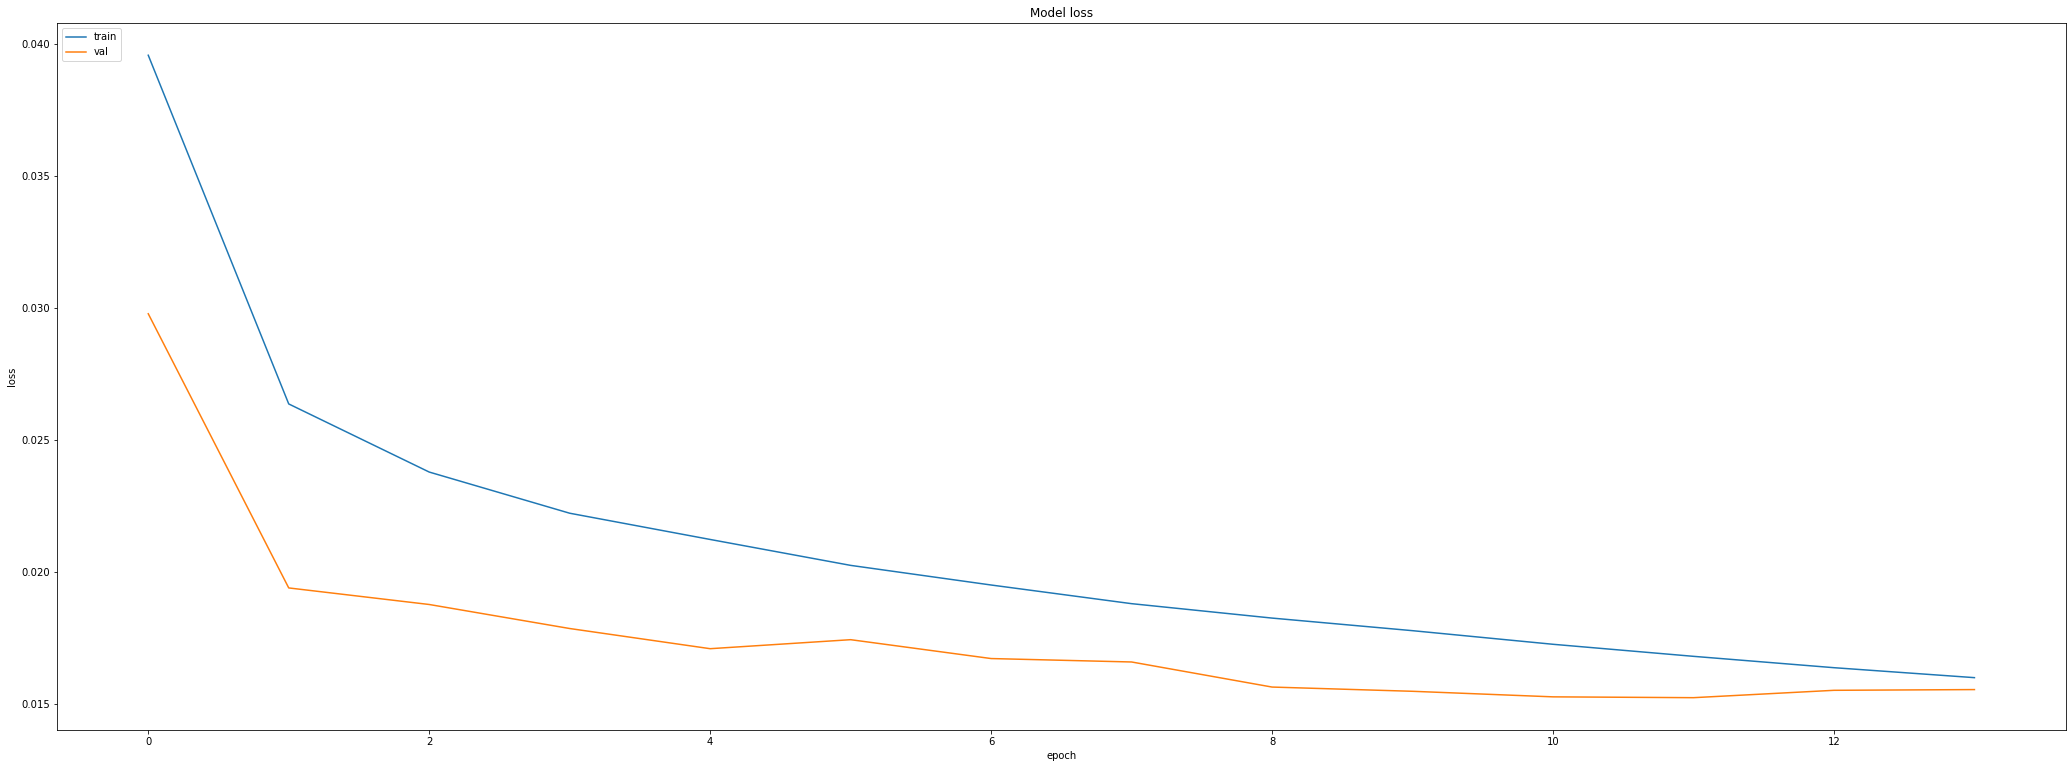

In [13]:
# Model Loss Chart
fig = plt.figure()
plt.figure(figsize=(36, 13))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [14]:
# Exporting loss values during the training by epoch
np.save('./outputs/MODEL/training_loss.npy', history.history['loss'])
np.save('./outputs/MODEL/val_loss.npy', history.history['val_loss'])

## 6.   Check point: verify the performance on test set

In [16]:
y_est = modelo.predict([X_encoder_test, X_decoder_test])

In [17]:
# Exporting the tensor forecasting before transformation to the original scaler
np.save('./outputs/MODEL/y_estimado_antes_minmax.npy', y_est)

In [18]:
scalers = pk.load(open("./internal_inputs/MINMAX/scalers.pkl",'rb'))
scaler = scalers['Energy_Demand']

(array([4.314e+03, 3.018e+03, 9.210e+02, 2.070e+02, 4.900e+01, 1.600e+01,
        1.100e+01, 3.000e+00, 2.000e+00, 4.000e+00]),
 array([ 0.51056912,  1.72960257,  2.94863602,  4.16766947,  5.38670292,
         6.60573637,  7.82476982,  9.04380327, 10.26283672, 11.48187017,
        12.70090362]),
 <BarContainer object of 10 artists>)

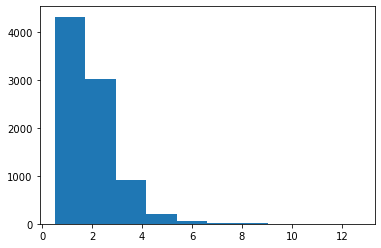

In [20]:
n = y_est.shape[0]
forecast_mape = []
for i in range(n):
    y_test_original = scaler.inverse_transform(y_test[i-1])
    y_est_final = scaler.inverse_transform(y_est[i-1])
    mape = mean_absolute_percentage_error(y_test_original,y_est_final) * 100
    forecast_mape.append(mape)
plt.hist(forecast_mape)

## 7.   Exporting the model

In [57]:
modelo.save('./outputs/MODEL/modelo_2.h5')

<summary>
    <font size="4" color="gray"> Maestría en Ciencia de Datos | Universidad de Sonora </font>
</summary>
<font size="1" color="gray"> Blvd. Luis Encinas y Rosales s/n Col. Centro. Edificio 3K1 planta baja C.P. 83000, Hermosillo, Sonora, México </font>
<font size="1" color="gray"> mcd@unison.mx </font>
<font size="1" color="gray"> Tel: +52 (662) 259 2155  </font>